In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import pathlib
import math
import sklearn
import torch_optimizer as optim
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
from metrics import *
from torch_geometric.nn import GCNConv, GATConv, global_max_pool as gmp, global_add_pool as gap,global_mean_pool as gep,global_sort_pool
from torch_geometric.utils import dropout_adj
import networkx as nx

import biographs as bg
from Bio import SeqIO
from Bio.PDB.PDBParser import PDBParser

In [2]:

# Check if CUDA (GPU) is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [3]:
ftrs = np.load("cas13a_embedding.npy", allow_pickle=True)
print(ftrs.shape)

(1159, 1024)


In [3]:
import MDAnalysis as mda

workdir = '/Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test'

In [80]:
import MDAnalysis as mda

workdir = '/Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test'
# Load the DCD trajectory file and associated topology (PSF or PDB file)
# dcd_file = os.path.join(workdir, "crRNA_R1-3_network_reducedTraj.dcd")
# topology_file = os.path.join(workdir, "crRNA_R1-3_network_reducedTraj.pdb")  # or "your_topology_file.pdb"

dcd_file = os.path.join(workdir, "tgRNA_network_reducedTraj_frame150.dcd")
topology_file = os.path.join(workdir, "tgRNA_network_reducedTraj.pdb")  # or "your_topology_file.pdb"

os.makedirs(os.path.join(workdir, "tgRNA_frames"), exist_ok = True)
# Create a Universe object to represent the system
u = mda.Universe(topology_file, dcd_file)

# Iterate over each frame in the trajectory
for ts in u.trajectory:
    # Create a PDB filename for the current frame (you can modify the naming as needed)
    pdb_filename = os.path.join(workdir,f"tgRNA_frames/frame_{ts.frame}.pdb")
    ag = u.select_atoms("protein")

    # Write the coordinates of the current frame to the PDB file
    with mda.Writer(pdb_filename, bonds=None, n_atoms=ag.atoms.n_atoms) as pdb:
        pdb.write(ag.atoms)

    print(f"Saved PDB file: {pdb_filename}")


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:753: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_0.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_1.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_2.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_3.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_4.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_5.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_6.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_7.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_class

Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_71.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_72.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_73.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_74.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_75.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_76.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_77.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_78.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/G

Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_141.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_142.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_143.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_144.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_145.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_146.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_147.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/LabWork/GNN_classifier/PPI_GNN/test/tgRNA_frames/frame_148.pdb
Saved PDB file: /Users/souviksinha/Desktop/Palermo_Lab/L

In [4]:
from bio_embeddings.embed import SeqVecEmbedder

# Dictionary for getting Residue symbols
ressymbl = {'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU':'E', 'PHE': 'F', 'GLY': 'G', 'HIE': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN':'Q', 'ARG':'R', 'SER': 'S','THR': 'T', 'VAL': 'V', 'TRP':'W', 'TYR': 'Y'}
# get structure from a pdb file
# Uses biopython
def get_structure(file):
    parser = PDBParser()
    structure = parser.get_structure(id, file) # return a Structure object.
    return structure

# Function to get sequence from pdb structure
# Uses structure made using biopython
# Those residues for which symbols are U / X are converted into A
def get_sequence(structure):
    sequence =""
    for model in structure:
      for chain in model:
        for residue in chain:
          if residue.get_resname() in ressymbl.keys():
              sequence = sequence+ ressymbl[residue.get_resname()]
    return sequence

# Define the protein sequence
# seq = 'MKVTKVGGISHKKYTSEGRLVKSESEENRTDERLSALLNMRLDMYIKNPSSTETKENQKRIGKLKKFFSNKMVYLKDNTLSLKNGKKENIDREYSETDILESDVRDKKNFAVLKKIYLNENVNSEELEVFRNDIKKKLNKINSLKYSFEKNKANYQKINENNIEKVEGKSKRNIIYDYYRESAKRDAYVSNVKEAFDKLYKEEDIAKLVLEIENLTKLEKYKIREFYHEIIGRKNDKENFAKIIYEEIQNVNNMKELIEKVPDMSELKKSQVFYKYYLDKEELNDKNIKYAFCHFVEIEMSQLLKNYVYKRLSNISNDKIKRIFEYQNLKKLIENKLLNKLDTYVRNCGKYNYYLQDGEIATSDFIARNRQNEAFLRNIIGVSSVAYFSLRNILETENENDITGRMRGKTVKNNKGEEKYVSGEVDKIYNENKKNEVKENLKMFYSYDFNMDNKNEIEDFFANIDEAISSIRHGIVHFNLELEGKDIFAFKNIAPSEISKKMFQNEINEKKLKLKIFRQLNSANVFRYLEKYKILNYLKRTRFEFVNKNIPFVPSFTKLYSRIDDLKNSLGIYWKTPKTNDDNKTKEIIDAQIYLLKNIYYGEFLNYFMSNNGNFFEISKEIIELNKNDKRNLKTGFYKLQKFEDIQEKIPKEYLANIQSLYMINAGNQDEEEKDTYIDFIQKIFLKGFMTYLANNGRLSLIYIGSDEETNTSLAEKKQEFDKFLKKYEQNNNIKIPYEINEFLREIKLGNILKYTERLNMFYLILKLLNHKELTNLKGSLEKYQSANKEEAFSDQLELINLLNLDNNRVTEDFELEADEIGKFLDFNGNKVKDNKELKKFDTNKIYFDGENIIKHRAFYNIKKYGMLNLLEKIADKAGYKISIEELKKYSNKKNEIEKNHKMQENLHRKYARPRKDEKFTDEDYESYKQAIENIEEYTHLKNKVEFNELNLLQGLLLRILHRLVGYTSIWERDLRFRLKGEFPENQYIEEIFNFENKKNVKYKGGQIVEKYIKFYKELHQNDEVKINKYSSANIKVLKQEKKDLYIANYIAAFNYIPHAEISLLEVLENLRKLLSYDRKLKNAVMKSVVDILKEYGFVATFKIGADKKIGIQTLESEKIVHLKNLKKKKLMTDRNSEELCKLVKIMFEYKMEEKKSEN'
# seq = get_sequence(get_structure(os.path.join(workdir, "crRNA_R1-3_network_reducedTraj.pdb")))
seq = get_sequence(get_structure(os.path.join(workdir, "tgRNA_network_reducedTraj.pdb")))
# Create an instance of the SeqVecEmbedder
embedder = SeqVecEmbedder()

# Obtain the embedding of the protein sequence
embedding = embedder.embed(seq)

# Convert the embedding to a PyTorch tensor on CPU
protein_embd = torch.tensor(embedding).sum(dim=0).cpu().numpy()
print(protein_embd.shape)

(1153, 1024)


In [77]:
from torch_geometric.data import Dataset, Dataset, download_url, Data,  Batch

# list of 20 proteins
pro_res_table = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Dictionary for getting Residue symbols
ressymbl = {'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU':'E', 'PHE': 'F', 'GLY': 'G', 'HIE': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN':'Q', 'ARG':'R', 'SER': 'S','THR': 'T', 'VAL': 'V', 'TRP':'W', 'TYR': 'Y'}


class ProteinDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(ProteinDataset, self).__init__(root, transform=None,
                 pre_transform=None)
        self.data = self.processed_paths
        #self.processed_dir = "../human_features/processed/"
        # self.data = torch.load(self.processed_paths)
        # print("Daata si {}". format(self.data))

    @property
    def raw_file_names(self):

#         return [filename for filename in os.scandir(self.root)] # A list of files in the raw directory which needs to be found in order to skip the download. (this file path is also raw_path)
        files = [filename for filename in os.scandir(self.root+"/raw")]
#         print(files)
#         print(self.raw_paths)
        return files


    
    @property
    def processed_file_names(self):
#         print(self.raw_paths)
        file_names = [file.split('/')[0]+"/"+file.split('/')[1]+"/"+file.split('/')[4] for file in self.raw_paths]
#         file = self.raw_paths[0]
#         print(file_names)
#         return [os.path.splitext(os.path.basename(file))[0]+'.pt' for file in self.raw_paths] # A list of files in the processed_dir which needs to be found in order to skip the processing. If *.pt not found, data will be processed
        return [os.path.splitext(os.path.basename(file))[0]+'.pt' for file in file_names]
    def download(self):
        # Download to `self.raw_dir`.
        pass

    def process(self):
        # Read data into huge `Data` list.
        self.data = self.processed_paths


        data_list =[]
        count = 0
        file_names = [file.split('/')[0]+"/"+file.split('/')[1]+"/"+file.split('/')[4] for file in self.raw_paths]
#         for file in tqdm(self.raw_paths): # tqdm is a progress bar library that can be used to visualize progress when iterating through a sequence (in this case, file paths).
        for file in tqdm(file_names): # tqdm is a progress bar library that can be used to visualize progress when iterating through a sequence (in this case, file paths).
           if(pathlib.Path(file).suffix ==".pdb"): # checks if the current file has a ".pdb" extension. This is done using pathlib.Path(file).suffix, which returns the file extension.

               try:
                struct = self._get_structure(file) # extract structural information from the PDB file (file)
               except:
                print('except', file)
                continue
               seq = self._get_sequence(struct) # extract the sequence information from the structural information (struct)

          # node features extracted
              #  node_feats = self._get_one_hot_symbftrs(seq) # extract node features (one-hot encoded symbol features) from the sequence (seq)
               node_feats = torch.tensor(protein_embd) # extract node features (one-hot encoded symbol features) from the sequence (seq)

          #edge-index extracted


               mat = self._get_adjacency(file) # extract the adjacency matrix (mat) from the PDB file (file

           # if sequence size > matrix dimensions
               if(mat.shape[0] < torch.Tensor.size(node_feats)[0]) :
                 #node_feats = torch.tensor(ftrs.item()[os.path.splitext(os.path.basename(file))[0]])
                 edge_index = self._get_edgeindex(file, mat)

                 print(f'Node features size :{torch.Tensor.size(node_feats)}')
                 print(f'mat size :{mat.shape}')
          # create data object

                 data = Data(x = node_feats, edge_index = edge_index )
                 count += 1
                 data_list.append(data)
                 torch.save(data, self.processed_dir + "/"+ os.path.splitext(os.path.basename(file))[0]+'.pt')


               elif mat.shape[0] == torch.Tensor.size(node_feats)[0] :
                 #node_feats = torch.tensor(ftrs.item()[os.path.splitext(os.path.basename(file))[0]])
                 edge_index = self._get_edgeindex(file, mat)


                 print(f'Node features size :{torch.Tensor.size(node_feats)}')
                 print(f'mat size :{mat.shape}')

          # create data object

                 data = Data(x = node_feats, edge_index = edge_index )
                 count += 1

                 data_list.append(data)
                 torch.save(data, self.processed_dir + "/"+ os.path.splitext(os.path.basename(file))[0]+'.pt')

        self.data_prot = data_list
        print(count)


        # data, slices = self.collate(data_list)
        # torch.save((data, slices), self.processed_paths[0])

    def __len__(self):
        return len(self.processed_file_names)


    # file stands for file path
    def __getitem__(self, idx):

        return self.data_prot[idx]

    # Biographs returns the network as a networkx.Graph object
    def _get_adjacency(self, file):
        edge_ind =[]
        molecule = bg.Pmolecule(file)
        network = molecule.network() # network.nodes[:10] can be used for output residue nodes; network = molecule.network(cutoff=8) to increase distance cut-off from 5A (default to 8A)
        mat = nx.adjacency_matrix(network) # calculates the adjacency matrix of a NetworkX graph ()
        m = mat.todense() # convert to dense matrix (probably internally using scipy library)
        return m


    # get adjacency matrix in coo format to pass in GCNN model
    def _get_edgeindex(self, file, adjacency_mat):
        edge_ind = []
        m = self._get_adjacency(file) #
        #check_symmetric(m, rtol=1e-05, atol=1e-08)

        a = np.nonzero(m > 0)[0] # find the indices of nonzero elements in the matrix m. [row]
        b = np.nonzero(m > 0)[1] # find the indices of nonzero elements in the matrix m. [column]
        edge_ind.append(a) # These arrays represent the edge indices of the nonzero elements in the adjacency matrix.
        edge_ind.append(b)
        return torch.tensor(np.array(edge_ind), dtype= torch.long) # creates a PyTorch tensor from the concatenated arrays in edge_ind, converting it to a long data type tensor


    # get structure from a pdb file
    # Uses biopython
    def _get_structure(self, file):
        parser = PDBParser()
        structure = parser.get_structure(id, file) # return a Structure object.
        return structure

    # Function to get sequence from pdb structure
    # Uses structure made using biopython
    # Those residues for which symbols are U / X are converted into A
    def _get_sequence(self, structure):
        sequence =""
        for model in structure:
          for chain in model:
            for residue in chain:
              if residue.get_resname() in ressymbl.keys():
                  sequence = sequence+ ressymbl[residue.get_resname()]
        return sequence


    # One hot encoding for symbols
    def _get_one_hot_symbftrs(self, sequence):
        one_hot_symb = np.zeros((len(sequence),len(pro_res_table)))
        row= 0
        for res in sequence:
          col = pro_res_table.index(res)
          one_hot_symb[row][col]=1
          row +=1
        return torch.tensor(one_hot_symb, dtype= torch.float)


    # Residue features calculated from pcp_dict
    def _get_res_ftrs(self, sequence):
        res_ftrs_out = []
        for res in sequence:
          res_ftrs_out.append(pcp_dict[res])
        res_ftrs_out= np.array(res_ftrs_out)
        #print(res_ftrs_out.shape)
        return torch.tensor(res_ftrs_out, dtype = torch.float)


    # total features after concatenating one_hot_symbftrs and res_ftrs
    def _get_node_ftrs(self, sequence):
        one_hot_symb = one_hot_symbftrs(sequence)
        res_ftrs_out = res_ftrs(sequence)
        return torch.tensor(np.hstack((one_hot_symb, res_ftrs_out)), dtype = torch.float)


# prot_graphs = ProteinDataset("../human_features/")

In [82]:
# prot_graphs = ProteinDataset(root="crRNA_frames/")
prot_graphs = ProteinDataset(root="tgRNA_frames/")

['tgRNA_frames/raw/tgRNA_frames/raw/frame_122.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_136.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_30.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_24.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_18.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_19.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_25.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_31.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_137.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_123.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_109.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_135.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_121.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_27.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_33.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_32.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_26.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_120.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_134.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame

  0%|                                                                                                                                                     | 0/150 [00:00<?, ?it/s]/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
  1%|▉                                                                                                                                            | 1/150 [00:11<28:33, 11.50s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
  1%|█▉                                                                                                                                           | 2/150 [00:16<18:44,  7.60s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
  2%|██▊                                                                                                                                          | 3/150 [00:21<15:25,  6.30s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
  3%|███▊                                                                                                                                         | 4/150 [00:25<13:44,  5.65s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
  3%|████▋                                                                                                                                        | 5/150 [00:30<12:41,  5.25s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
  4%|█████▋                                                                                                                                       | 6/150 [00:34<12:04,  5.03s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
  5%|██████▌                                                                                                                                      | 7/150 [00:39<11:31,  4.84s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
  5%|███████▌                                                                                                                                     | 8/150 [00:43<11:10,  4.72s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
  6%|████████▍                                                                                                                                    | 9/150 [00:48<10:50,  4.62s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
  7%|█████████▎                                                                                                                                  | 10/150 [00:52<10:22,  4.45s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
  7%|██████████▎                                                                                                                                 | 11/150 [00:56<10:17,  4.44s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
  8%|███████████▏                                                                                                                                | 12/150 [01:01<10:29,  4.56s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
  9%|████████████▏                                                                                                                               | 13/150 [01:05<10:18,  4.51s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
  9%|█████████████                                                                                                                               | 14/150 [01:10<10:10,  4.49s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 10%|██████████████                                                                                                                              | 15/150 [01:14<10:04,  4.47s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 11%|██████████████▉                                                                                                                             | 16/150 [01:19<09:57,  4.46s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 11%|███████████████▊                                                                                                                            | 17/150 [01:23<09:52,  4.45s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 12%|████████████████▊                                                                                                                           | 18/150 [01:27<09:30,  4.32s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 13%|█████████████████▋                                                                                                                          | 19/150 [01:32<09:31,  4.36s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 13%|██████████████████▋                                                                                                                         | 20/150 [01:36<09:35,  4.42s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 14%|███████████████████▌                                                                                                                        | 21/150 [01:41<09:32,  4.44s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 15%|████████████████████▌                                                                                                                       | 22/150 [01:45<09:28,  4.44s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 15%|█████████████████████▍                                                                                                                      | 23/150 [01:50<09:24,  4.44s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 16%|██████████████████████▍                                                                                                                     | 24/150 [01:54<09:20,  4.45s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 17%|███████████████████████▎                                                                                                                    | 25/150 [01:59<09:22,  4.50s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 17%|████████████████████████▎                                                                                                                   | 26/150 [02:02<08:48,  4.26s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 18%|█████████████████████████▏                                                                                                                  | 27/150 [02:06<08:26,  4.12s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 19%|██████████████████████████▏                                                                                                                 | 28/150 [02:10<08:11,  4.03s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 19%|███████████████████████████                                                                                                                 | 29/150 [02:14<08:00,  3.97s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 20%|████████████████████████████                                                                                                                | 30/150 [02:18<07:49,  3.91s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 21%|████████████████████████████▉                                                                                                               | 31/150 [02:21<07:35,  3.83s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 21%|█████████████████████████████▊                                                                                                              | 32/150 [02:25<07:21,  3.74s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 22%|██████████████████████████████▊                                                                                                             | 33/150 [02:29<07:31,  3.86s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 23%|███████████████████████████████▋                                                                                                            | 34/150 [02:32<07:15,  3.76s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 23%|████████████████████████████████▋                                                                                                           | 35/150 [02:36<07:03,  3.68s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 24%|█████████████████████████████████▌                                                                                                          | 36/150 [02:39<06:52,  3.62s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 25%|██████████████████████████████████▌                                                                                                         | 37/150 [02:44<07:17,  3.88s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 25%|███████████████████████████████████▍                                                                                                        | 38/150 [02:48<07:08,  3.83s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 26%|████████████████████████████████████▍                                                                                                       | 39/150 [02:52<07:30,  4.06s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 27%|█████████████████████████████████████▎                                                                                                      | 40/150 [02:57<08:00,  4.37s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 27%|██████████████████████████████████████▎                                                                                                     | 41/150 [03:02<08:07,  4.47s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 28%|███████████████████████████████████████▏                                                                                                    | 42/150 [03:06<07:53,  4.38s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 29%|████████████████████████████████████████▏                                                                                                   | 43/150 [03:11<07:56,  4.46s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 29%|█████████████████████████████████████████                                                                                                   | 44/150 [03:15<07:50,  4.44s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 30%|██████████████████████████████████████████                                                                                                  | 45/150 [03:20<07:50,  4.48s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 31%|██████████████████████████████████████████▉                                                                                                 | 46/150 [03:24<07:50,  4.53s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 31%|███████████████████████████████████████████▊                                                                                                | 47/150 [03:29<07:33,  4.41s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 32%|████████████████████████████████████████████▊                                                                                               | 48/150 [03:34<07:59,  4.71s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 33%|█████████████████████████████████████████████▋                                                                                              | 49/150 [03:39<08:07,  4.83s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 33%|██████████████████████████████████████████████▋                                                                                             | 50/150 [03:44<07:58,  4.78s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 34%|███████████████████████████████████████████████▌                                                                                            | 51/150 [03:48<07:52,  4.77s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 35%|████████████████████████████████████████████████▌                                                                                           | 52/150 [03:53<07:39,  4.69s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 35%|█████████████████████████████████████████████████▍                                                                                          | 53/150 [03:58<07:33,  4.68s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 36%|██████████████████████████████████████████████████▍                                                                                         | 54/150 [04:02<07:28,  4.67s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 37%|███████████████████████████████████████████████████▎                                                                                        | 55/150 [04:06<07:08,  4.51s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 37%|████████████████████████████████████████████████████▎                                                                                       | 56/150 [04:11<07:09,  4.57s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 38%|█████████████████████████████████████████████████████▏                                                                                      | 57/150 [04:16<07:02,  4.55s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 39%|██████████████████████████████████████████████████████▏                                                                                     | 58/150 [04:19<06:36,  4.31s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 39%|███████████████████████████████████████████████████████                                                                                     | 59/150 [04:24<06:34,  4.33s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 40%|████████████████████████████████████████████████████████                                                                                    | 60/150 [04:28<06:29,  4.33s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 41%|████████████████████████████████████████████████████████▉                                                                                   | 61/150 [04:32<06:24,  4.32s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 41%|█████████████████████████████████████████████████████████▊                                                                                  | 62/150 [04:37<06:19,  4.32s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 42%|██████████████████████████████████████████████████████████▊                                                                                 | 63/150 [04:41<06:14,  4.30s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 43%|███████████████████████████████████████████████████████████▋                                                                                | 64/150 [04:46<06:18,  4.41s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 43%|████████████████████████████████████████████████████████████▋                                                                               | 65/150 [04:50<06:09,  4.34s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 44%|█████████████████████████████████████████████████████████████▌                                                                              | 66/150 [04:54<05:58,  4.27s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 45%|██████████████████████████████████████████████████████████████▌                                                                             | 67/150 [04:58<05:47,  4.19s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 45%|███████████████████████████████████████████████████████████████▍                                                                            | 68/150 [05:01<05:29,  4.01s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 46%|████████████████████████████████████████████████████████████████▍                                                                           | 69/150 [05:05<05:21,  3.97s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 47%|█████████████████████████████████████████████████████████████████▎                                                                          | 70/150 [05:09<05:17,  3.97s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 47%|██████████████████████████████████████████████████████████████████▎                                                                         | 71/150 [05:13<05:10,  3.93s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 48%|███████████████████████████████████████████████████████████████████▏                                                                        | 72/150 [05:17<05:10,  3.98s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 49%|████████████████████████████████████████████████████████████████████▏                                                                       | 73/150 [05:21<05:01,  3.92s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 49%|█████████████████████████████████████████████████████████████████████                                                                       | 74/150 [05:25<04:58,  3.93s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 50%|██████████████████████████████████████████████████████████████████████                                                                      | 75/150 [05:28<04:42,  3.77s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 51%|██████████████████████████████████████████████████████████████████████▉                                                                     | 76/150 [05:32<04:41,  3.80s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 51%|███████████████████████████████████████████████████████████████████████▊                                                                    | 77/150 [05:36<04:33,  3.74s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 52%|████████████████████████████████████████████████████████████████████████▊                                                                   | 78/150 [05:40<04:27,  3.72s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 53%|█████████████████████████████████████████████████████████████████████████▋                                                                  | 79/150 [05:43<04:24,  3.73s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 53%|██████████████████████████████████████████████████████████████████████████▋                                                                 | 80/150 [05:47<04:18,  3.70s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 54%|███████████████████████████████████████████████████████████████████████████▌                                                                | 81/150 [05:51<04:16,  3.72s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 55%|████████████████████████████████████████████████████████████████████████████▌                                                               | 82/150 [05:55<04:26,  3.92s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 55%|█████████████████████████████████████████████████████████████████████████████▍                                                              | 83/150 [05:59<04:29,  4.02s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 56%|██████████████████████████████████████████████████████████████████████████████▍                                                             | 84/150 [06:03<04:16,  3.89s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 57%|███████████████████████████████████████████████████████████████████████████████▎                                                            | 85/150 [06:08<04:27,  4.12s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 57%|████████████████████████████████████████████████████████████████████████████████▎                                                           | 86/150 [06:12<04:21,  4.09s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                          | 87/150 [06:15<04:10,  3.98s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 59%|██████████████████████████████████████████████████████████████████████████████████▏                                                         | 88/150 [06:19<04:02,  3.90s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 59%|███████████████████████████████████████████████████████████████████████████████████                                                         | 89/150 [06:23<03:53,  3.82s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 90/150 [06:26<03:44,  3.74s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 61%|████████████████████████████████████████████████████████████████████████████████████▉                                                       | 91/150 [06:30<03:38,  3.70s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 61%|█████████████████████████████████████████████████████████████████████████████████████▊                                                      | 92/150 [06:33<03:25,  3.54s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                     | 93/150 [06:37<03:22,  3.55s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 63%|███████████████████████████████████████████████████████████████████████████████████████▋                                                    | 94/150 [06:40<03:20,  3.57s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 63%|████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 95/150 [06:44<03:18,  3.61s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 96/150 [06:47<03:14,  3.60s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 65%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 97/150 [06:51<03:10,  3.60s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 65%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                | 98/150 [06:55<03:08,  3.62s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 99/150 [06:58<03:05,  3.65s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 100/150 [07:02<02:56,  3.53s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 67%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 101/150 [07:05<02:55,  3.58s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 102/150 [07:09<02:53,  3.61s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 69%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 103/150 [07:13<02:50,  3.63s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 69%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 104/150 [07:16<02:47,  3.65s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 105/150 [07:20<02:46,  3.70s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 106/150 [07:24<02:43,  3.72s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 107/150 [07:28<02:38,  3.68s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 108/150 [07:31<02:27,  3.50s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 109/150 [07:34<02:25,  3.56s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 110/150 [07:38<02:23,  3.58s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 111/150 [07:42<02:19,  3.59s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 112/150 [07:45<02:17,  3.61s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 113/150 [07:49<02:14,  3.63s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 114/150 [07:53<02:11,  3.65s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 115/150 [07:56<02:07,  3.66s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 116/150 [08:00<02:07,  3.74s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 117/150 [08:04<01:58,  3.60s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 118/150 [08:07<01:56,  3.63s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 119/150 [08:11<01:52,  3.64s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 120/150 [08:15<01:50,  3.68s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 121/150 [08:19<01:48,  3.74s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 122/150 [08:22<01:45,  3.76s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 123/150 [08:26<01:41,  3.77s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 124/150 [08:30<01:40,  3.88s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 125/150 [08:35<01:45,  4.22s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 126/150 [08:40<01:45,  4.39s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 127/150 [08:45<01:48,  4.70s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 128/150 [08:51<01:45,  4.82s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 129/150 [08:55<01:36,  4.61s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 130/150 [08:59<01:32,  4.65s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 131/150 [09:05<01:31,  4.83s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 132/150 [09:09<01:21,  4.53s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 133/150 [09:12<01:11,  4.20s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 134/150 [09:17<01:10,  4.38s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 135/150 [09:22<01:08,  4.55s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 136/150 [09:27<01:05,  4.65s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 137/150 [09:31<00:58,  4.48s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 138/150 [09:34<00:51,  4.28s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 139/150 [09:38<00:45,  4.15s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 140/150 [09:42<00:40,  4.05s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 141/150 [09:46<00:35,  3.99s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 142/150 [09:49<00:30,  3.83s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 143/150 [09:53<00:26,  3.85s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 144/150 [09:58<00:23,  3.97s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 145/150 [10:01<00:19,  3.92s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 146/150 [10:06<00:15,  3.99s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 147/150 [10:09<00:11,  3.91s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 148/150 [10:13<00:07,  3.82s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 149/150 [10:16<00:03,  3.74s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 19604
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [10:20<00:00,  4.13s/it]

Node features size :torch.Size([1153, 1024])
mat size :(1153, 1153)
150
['tgRNA_frames/raw/tgRNA_frames/raw/frame_122.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_136.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_30.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_24.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_18.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_19.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_25.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_31.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_137.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_123.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_109.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_135.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_121.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_27.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_33.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_32.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_26.pdb', 'tgRNA_frames/raw/tgRNA_frames/raw/frame_120.pdb', 'tgRNA_frames/raw/t

In [84]:
npy_ar = np.load('../human_features/npy_file_new(human_dataset).npy')
print(npy_ar.shape)

(22217, 7)


In [87]:
print(npy_ar[100:110, 2], npy_ar[100:110, 5], npy_ar[100:110, 6])

['1D0G' '1KSG' '1RV1' '2K45' '2WH0' '2DO4' '1KHU' '6F3T' '1MX3' '2DMQ'] ['1F2H' '1X3S' '1NB8' '1M2Z' '2KY5' '1E3G' '1ABN' '2AGH' '2GPO' '1DEV'] ['1' '1' '1' '1' '1' '1' '1' '1' '1' '1']


In [128]:
# print(trainset.indices)
# trainloader = DataLoader(dataset=trainset, batch_size=64, num_workers=0)
# print(trainloader.batch_size)
# for batch in trainloader:
# #     print('a')
#     data, labels = batch
#     print(labels)

In [5]:
import os
import glob
import torch
from torch.utils.data import Dataset
from torch_geometric.data import DataLoader, Data

class ManuallyLabelledDataset(Dataset):
    def __init__(self, label0_dir, label1_dir):
        self.label0_files = glob.glob(os.path.join(label0_dir, "*.pt"))
        self.label1_files = glob.glob(os.path.join(label1_dir, "*.pt"))

        self.files = self.label0_files + self.label1_files
        self.labels = [0] * len(self.label0_files) + [1] * len(self.label1_files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        
        data = torch.load(file_path)
        data.y = torch.tensor([label], dtype=torch.float32)
        
        return data

# Define paths to the directories
label0_dir = "crRNA_frames/processed"
label1_dir = "tgRNA_frames/processed"

# Create dataset instance
dataset = ManuallyLabelledDataset(label0_dir=label0_dir, label1_dir=label1_dir)

# Split into training and testing sets
print("Size is:", len(dataset))

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print(train_size, test_size)

trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader
trainloader = DataLoader(dataset=trainset, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=32, shuffle=False)

# Verify the batched data
for step, batch in enumerate(trainloader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {batch.num_graphs}')
    print(f'Node feature shape: {batch.x.shape}')
    print(f'Edge index shape: {batch.edge_index.shape}')
    print(f'Batch tensor: {batch.batch}') 
    print(f'Label tensor: {batch.y}')
    print(batch)
    print()
    break  # Remove this if you want to see all batches


Size is: 301
240 61


/Users/souviksinha/miniconda3/envs/py39_2/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Step 1:
Number of graphs in the current batch: 32
Node feature shape: torch.Size([36896, 1024])
Edge index shape: torch.Size([2, 465452])
Batch tensor: tensor([ 0,  0,  0,  ..., 31, 31, 31])
Label tensor: tensor([0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
        0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0.])
DataBatch(x=[36896, 1024], edge_index=[2, 465452], y=[32], batch=[36896], ptr=[33])



1. Node feature shape: torch.Size([11530, 1024])
The node features for all nodes in the batch (10*1153), with each node having 1024 features. The first dimension (11530) represents the total number of nodes across all graphs in the batch.
2. Batch tensor: tensor([0, 0, 0,  ..., 9, 9, 9])
The batch tensor is a 1-dimensional tensor where each element indicates the graph index for the corresponding node.
3. Edge index shape: torch.Size([2, 145596])
The edge indices for all edges in the batch. The first dimension (2) is because edges are represented as pairs of node indices (source and target). The second dimension (145734) is the total number of edges in the batch.

In [6]:
print(len(dataset))
print(len(trainloader))
print(len(testloader))

total_samples = len(dataset)
n_iterations = math.ceil(total_samples/5)
print(f'iteration:{n_iterations}')

301
8
2
iteration:61


In [7]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, num_features_pro, hidden_channels, num_classes):
        super(GCN, self).__init__()
#         torch.manual_seed(12345)
#         self.conv1 = GCNConv(num_features_pro, hidden_channels)
        self.conv1 = GCNConv(num_features_pro, num_features_pro)
#         self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv2 = GCNConv(num_features_pro, hidden_channels)
        self.fc1 = Linear(hidden_channels, 128)
        
        self.fc2 = Linear(128, 64)
        self.out = Linear(64, num_classes)
        self.relu = torch.nn.LeakyReLU()
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
#         x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        
        # add some dense layers
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.out(x)

        # 3. Apply a final classifier
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.lin(x)
        
        return x

model = GCN(num_features_pro=1024, hidden_channels=256, num_classes=2)
print(model)



GCN(
  (conv1): GCNConv(1024, 1024)
  (conv2): GCNConv(1024, 256)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [8]:
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [62]:
optimizer =  torch.optim.Adam(model.parameters(), lr= 0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    scheduler = MultiStepLR(optimizer, milestones=[5,8], gamma=0.5)

    for data in trainloader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
#         print(out)
        label = data.y.long().to(device)
        loss = criterion(out, label)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    scheduler.step()
    print(f'Epoch {epoch}  [==============================] - train_loss : {loss}')
        
            
def test(loader):
        model.eval()

        correct = 0
        for data in loader:  # Iterate in batches over the training/test dataset.
            out = model(data.x, data.edge_index, data.batch)  
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 10):
    train(epoch)
    train_acc = test(trainloader)
    test_acc = test(testloader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch 1  [==============================] - train_loss : 0.7156450152397156
Epoch: 001, Train Acc: 0.5125, Test Acc: 0.4426
Epoch 2  [==============================] - train_loss : 0.6989957094192505
Epoch: 002, Train Acc: 0.5125, Test Acc: 0.4426
Epoch 3  [==============================] - train_loss : 0.6917089819908142
Epoch: 003, Train Acc: 0.5125, Test Acc: 0.4426
Epoch 4  [==============================] - train_loss : 0.34015515446662903
Epoch: 004, Train Acc: 0.7750, Test Acc: 0.7377
Epoch 5  [==============================] - train_loss : 0.1958349049091339
Epoch: 005, Train Acc: 0.9875, Test Acc: 0.9672
Epoch 6  [==============================] - train_loss : 0.017548970878124237
Epoch: 006, Train Acc: 0.9583, Test Acc: 0.9508
Epoch 7  [==============================] - train_loss : 0.004489968065172434
Epoch: 007, Train Acc: 1.0000, Test Acc: 1.0000
Epoch 8  [==============================] - train_loss : 0.006075399927794933
Epoch: 008, Train Acc: 1.0000, Test Acc: 1.0000
E

In [64]:
import torch
from torch.optim.lr_scheduler import MultiStepLR
from torch_geometric.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Early stopping parameters
patience = 4
best_test_acc = 0
epochs_no_improve = 0
early_stop = False

def train(epoch):
    model.train()
    scheduler = MultiStepLR(optimizer, milestones=[6, 9], gamma=0.5)

    total_loss = 0
    for data in trainloader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        
        # Assuming the model output is of shape [batch_size, 2]
        label = data.y.long().to(device)  # Ensure labels are of type long
        loss = criterion(out, label)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        total_loss += loss.item()
    scheduler.step()
    avg_loss = total_loss / len(trainloader)
    print(f'Epoch {epoch}  [==============================] - train_loss : {avg_loss:.4f}')

def evaluate(loader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for data in loader:  # Iterate in batches over the dataset.
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)  
            
            # Use softmax to get probabilities
            prob = torch.softmax(out, dim=1)
            pred = prob.argmax(dim=1)  # Use the class with highest probability
            
            y_true.extend(data.y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    return accuracy, precision, recall, f1, roc_auc

for epoch in range(1, 11):
    train(epoch)
    train_acc, train_prec, train_recall, train_f1, train_roc_auc = evaluate(trainloader)
    test_acc, test_prec, test_recall, test_f1, test_roc_auc = evaluate(testloader)
    
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    print(f'Precision: Train: {train_prec:.4f}, Test: {test_prec:.4f}')
    print(f'Recall: Train: {train_recall:.4f}, Test: {test_recall:.4f}')
    print(f'F1-Score: Train: {train_f1:.4f}, Test: {test_f1:.4f}')
    print(f'ROC-AUC: Train: {train_roc_auc:.4f}, Test: {test_roc_auc:.4f}')
    
    # Early stopping logic
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping!')
            early_stop = True
            break

# Load the best model if early stopping was triggered
if early_stop:
    model.load_state_dict(torch.load('best_model.pt'))


Epoch 1  [==============================] - train_loss : 0.4758
Epoch: 001, Train Acc: 0.8792, Test Acc: 0.8361
Precision: Train: 0.8092, Test: 0.7297
Recall: Train: 1.0000, Test: 1.0000
F1-Score: Train: 0.8945, Test: 0.8437
ROC-AUC: Train: 0.8761, Test: 0.8529
Epoch 2  [==============================] - train_loss : 0.3249
Epoch: 002, Train Acc: 0.9833, Test Acc: 1.0000
Precision: Train: 1.0000, Test: 1.0000
Recall: Train: 0.9675, Test: 1.0000
F1-Score: Train: 0.9835, Test: 1.0000
ROC-AUC: Train: 0.9837, Test: 1.0000
Epoch 3  [==============================] - train_loss : 0.0787
Epoch: 003, Train Acc: 1.0000, Test Acc: 0.9836
Precision: Train: 1.0000, Test: 0.9643
Recall: Train: 1.0000, Test: 1.0000
F1-Score: Train: 1.0000, Test: 0.9818
ROC-AUC: Train: 1.0000, Test: 0.9853
Epoch 4  [==============================] - train_loss : 0.0642
Epoch: 004, Train Acc: 0.9875, Test Acc: 0.9672
Precision: Train: 0.9762, Test: 0.9310
Recall: Train: 1.0000, Test: 1.0000
F1-Score: Train: 0.9880, Te

In [9]:
from torch_geometric.explain import Explainer, GNNExplainer

# Define the explainer
explainer_pyg = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw',
    ),
)

# Select a sample from the testset
data = testset[0].to(device)

# Explain the prediction for this graph
explanation = explainer_pyg(data.x, data.edge_index, batch=data.batch)

# Print edge mask and node mask
print("Edge mask:", explanation.edge_mask)
print("Node mask:", explanation.node_mask)



Edge mask: tensor([0.5622, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000])
Node mask: tensor([[0.2877, 0.1582, 0.2057,  ..., 0.2790, 0.5072, 0.5791],
        [0.2774, 0.1326, 0.3810,  ..., 0.2867, 0.6468, 0.2665],
        [0.1237, 0.1719, 0.2666,  ..., 0.2111, 0.4880, 0.2504],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [10]:
print(explanation.node_mask.shape)
print(explanation.edge_mask.shape)
print(sorted(explanation.edge_mask, reverse=True)[:10])

torch.Size([1153, 1024])
torch.Size([14476])
[tensor(0.7157), tensor(0.7124), tensor(0.7100), tensor(0.7066), tensor(0.7031), tensor(0.7030), tensor(0.7027), tensor(0.7024), tensor(0.6974), tensor(0.6960)]


# Running explaination on multiple-graphs and average

In [145]:
# Function to explain a single graph
def explain_graph(data):
    explanation = explainer_pyg(data.x, data.edge_index, batch=data.batch)
    return explanation.edge_mask

# Collect explanations for multiple graphs
edge_masks = []
for data in testset:
    data = data.to(device)
    edge_mask = explain_graph(data)
    edge_masks.append(edge_mask.cpu().detach().numpy())

# Compute the average edge mask
average_edge_mask = np.mean(edge_masks, axis=0)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (61,) + inhomogeneous part.

In [158]:
print(len(edge_masks[60]))
# print(edge_masks)
for i, count in enumerate(edge_masks):
    print(count.shape)
# combined_array = np.stack(edge_masks)

# # Sum over the first axis
# sum_array = np.sum(combined_array, axis=0)
# print(sum_array.shape)

14684
(14576,)
(14526,)
(14566,)
(14432,)
(14660,)
(14484,)
(14512,)
(14634,)
(14572,)
(14578,)
(14450,)
(14470,)
(14588,)
(14376,)
(14652,)
(14582,)
(14500,)
(14580,)
(14440,)
(14668,)
(14614,)
(14588,)
(14536,)
(14506,)
(14624,)
(14460,)
(14458,)
(14380,)
(14456,)
(14592,)
(14662,)
(14652,)
(14552,)
(14456,)
(14526,)
(14524,)
(14434,)
(14426,)
(14530,)
(14398,)
(14564,)
(14598,)
(14536,)
(14716,)
(14542,)
(14624,)
(14542,)
(14614,)
(14552,)
(14524,)
(14618,)
(14650,)
(14636,)
(14596,)
(14544,)
(14430,)
(14566,)
(14408,)
(14470,)
(14528,)
(14684,)


# Visualize explaination (top 20 edges)

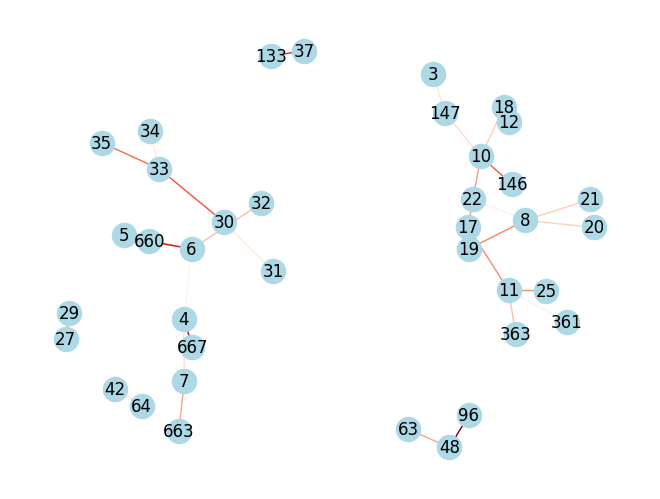

In [22]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

def visualize_top_subgraphs(data, output, edge_mask, top_n=10):
    # Convert data to networkx graph
    G = to_networkx(data, to_undirected=True)
    
    # Set edge weights from edge mask
    for i, (u, v) in enumerate(G.edges()):
        G[u][v]['weight'] = edge_mask[i].item()
    
    # Get top-N edges based on weight
    top_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:top_n]
    top_edges = [(u, v) for u, v, w in top_edges]

    # Create a subgraph containing the top-N edges
    subgraph = G.edge_subgraph(top_edges)
    
    # Plot the subgraph
    pos = nx.spring_layout(subgraph)
#     pos = nx.shell_layout(subgraph)
    edge_weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]
    nx.draw(subgraph, pos, with_labels=True, edge_color=edge_weights, edge_cmap=plt.cm.Reds, node_color='lightblue')
    
   # Add edge labels (weights) on top of the edges
#     edge_labels = {(u, v): f'{w:.4f}' for u, v, w in subgraph.edges(data='weight')}
#     nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)
#     nx.draw_networkx_edge_labels(subgraph, pos, edge_labels={(u, v): f'{w:.2f}' for u, v, w in subgraph.edges(data='weight')})
    plt.savefig(output, format="PNG")
    plt.show()

# Example usage (assuming 'data' and 'edge_mask' are defined)
visualize_top_subgraphs(data, "test1_top30.png", explanation.edge_mask, top_n=30)
# visualize_top_subgraphs(data, average_edge_mask, top_n=20)


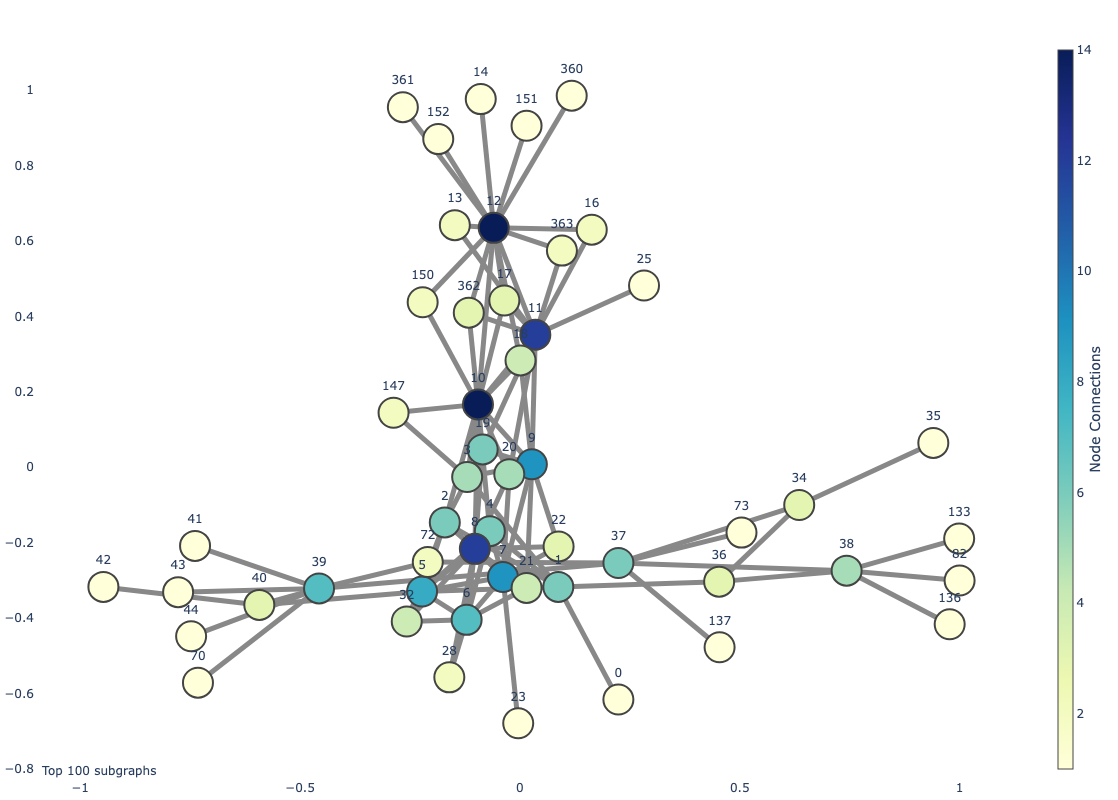

In [18]:
import networkx as nx
from torch_geometric.utils import to_networkx
import plotly.graph_objects as go

def visualize_top_subgraphs_plotly(data, edge_mask, top_n=10, save_path=None):
    # Convert data to networkx graph
    G = to_networkx(data, to_undirected=True)
    
    # Set edge weights from edge mask
    for i, (u, v) in enumerate(G.edges()):
        G[u][v]['weight'] = edge_mask[i].item()
    
    # Get top-N edges based on weight
    top_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:top_n]
    top_edges = [(u, v) for u, v, w in top_edges]

    # Create a subgraph containing the top-N edges
    subgraph = G.edge_subgraph(top_edges)

    edge_weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]
    # edge_weights = [float(subgraph[u][v]['weight']) for u, v in subgraph.edges()]

    # Get positions for all nodes in subgraph
    pos = nx.spring_layout(subgraph)

    edge_x = []
    edge_y = []
    for edge in subgraph.edges(data=True):
        # x, y = [], []
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        # x.append(x0)
        # x.append(x1)
        # x.append(None)

        # y.append(y0)
        # y.append(y1)
        # y.append(None)
        
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
    # print(edge_x)
    
    # Create Plotly edge traces
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    # edge_trace = []
    # for i, e in enumerate(subgraph.edges):
    #     trace_ = go.Scatter(
    #         x=edge_x[i], y=edge_y[i],
    #         mode="lines",
    #         line=dict(width=edge_weights[i]*5, color="#888"),
    #         hovertext=[str(edge_weights[i])],
    #         hoverinfo='text')
        
    #     edge_trace.append(trace_)

    node_x = []
    node_y = []
    node_text = []
    
    for node in subgraph.nodes():
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
            node_text.append(str(node))
        
    # Create Plotly node traces
    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        text=node_text,
        mode='markers+text',
        textposition='top center',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=30,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2)
    )

    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(subgraph.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append('# of connections: '+str(len(adjacencies[1])))
    
    node_trace.marker.color = node_adjacencies
    # node_trace.text = node_text



    # fig = go.Figure(data=[node_trace]+edge_trace[0:],
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        # title='<br>Network graph of top subgraph edges',
                        # paper_bgcolor='white',
                        plot_bgcolor='white',
                        titlefont_size=20,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            text="Top 100 subgraphs",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002)],
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False),
                        width=1000,
                        height=800)
                    )

    # for i in range(len(edge_weights)):
    #     fig.add_trace(
    #         go.Scatter(
    #             x=edge_x[i*3:i*3+2], 
    #             y=edge_y[i*3:i*3+2],
    #             mode='lines',
    #             line=dict(width=edge_weights[i]*10, color='blue'),
    #             hoverinfo='none',
    #             showlegend=False
    #         )
    #     )

    # Save the plot if save_path is provided
    if save_path:
        fig.write_image(save_path)
    fig.show()

# Example usage (assuming 'data' and 'edge_mask' are defined)
visualize_top_subgraphs_plotly(data, explanation.edge_mask, top_n=100, save_path='top100_subgraph_plotly.png')


In [ ]:
# 4 660 6 667 5 32 7 676 664 663 8 2 21 20 22 19 11 3 9 25 147 16 363 361 12 17 18 10 146 151
# 30 48 63 31 96 35 33 

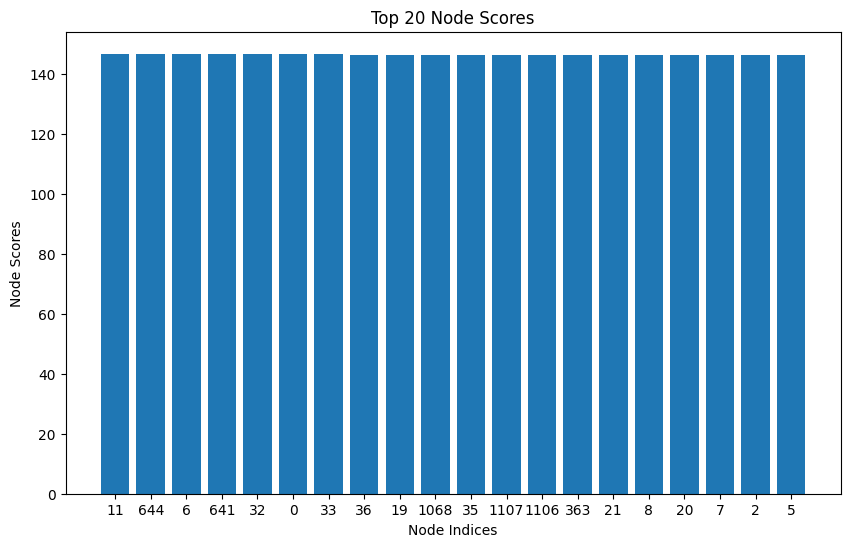

In [144]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_top_nodes(data, node_mask, top_k=20):
    # Sum the node mask across the features
    node_scores = node_mask.sum(dim=1)  # Sum along the feature dimension
    
    # Get the top k node indices based on the summed node scores
    top_k_values, top_k_indices = torch.topk(node_scores, top_k)
    top_k_values = top_k_values.detach().cpu().numpy()
    top_k_indices = top_k_indices.detach().cpu().numpy()
    
    # Ensure the indices are valid node indices in the graph
#     G = to_networkx(data, to_undirected=True)
    valid_indices = [idx for idx in top_k_indices if idx in G.nodes()]
    valid_scores = [top_k_values[i] for i, idx in enumerate(top_k_indices) if idx in G.nodes()]
    
    # Bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(valid_indices)), valid_scores, tick_label=valid_indices)
    plt.xlabel('Node Indices')
    plt.ylabel('Node Scores')
    plt.title('Top 20 Node Scores')
    plt.show()

    # Create a subgraph with the valid indices
#     subgraph = G.subgraph(valid_indices)
    
#     # Visualize the subgraph
#     pos = nx.spring_layout(subgraph)
#     nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
#     nx.draw_networkx_edge_labels(subgraph, pos, edge_labels={(u, v): f'{G[u][v].get("weight", 0):.2f}' for u, v in subgraph.edges()})
#     plt.show()


# Visualize the top node masks
visualize_top_nodes(data, explanation.node_mask)


1. torch.topk(node_mask, 10) : will return the top 10 values and their indices.
2. .indices extracts the indices of these top 10 values.
3. .detach() ensures no gradient information is stored.
4. .cpu() moves the tensor to the CPU (necessary if it was on a GPU).
5. .numpy() converts the result to a NumPy array.

In [111]:
x = explanation.node_mask.detach().cpu().numpy()
print(np.sum(x, axis=1)/x.shape[1])
print(np.sum(x, axis=1))

[0.14315937 0.14276347 0.14287207 ... 0.         0.         0.        ]
[146.5952  146.18979 146.301   ...   0.        0.        0.     ]


In [115]:
# Get top-N important nodes
top_nodes = torch.topk(explanation.node_mask, 10).indices.detach().cpu().numpy()
print(top_nodes)
print(top_nodes.shape)

[[727  82 234 ... 536 626 474]
 [ 81 340 607 ... 136 814 284]
 [980 232 534 ... 900 217 880]
 ...
 [  5   9   2 ...   1   3   7]
 [  5   9   2 ...   1   3   7]
 [  5   9   2 ...   1   3   7]]
(1153, 10)


In [138]:
G = to_networkx(data, to_undirected=True)
# print(G.nodes)
# for i in G.nodes:
#     print(i)
# Get top-N important nodes
node_scores = explanation.node_mask.sum(dim=1) 
top_nodes = torch.topk(node_scores, 10).indices.detach().cpu().numpy()

print(top_nodes)
# Ensure the indices are valid node indices in the graph
valid_indices = [idx for idx in top_nodes if idx in G.nodes]
print(valid_indices)
print(torch.topk(node_scores, 50))

[  11  644    6  641   32    0   33   36   19 1068]
[11, 644, 6, 641, 32, 0, 33, 36, 19, 1068]
torch.return_types.topk(
values=tensor([146.7986, 146.7762, 146.7630, 146.7138, 146.5983, 146.5952, 146.5580,
        146.5069, 146.4995, 146.4622, 146.4456, 146.4159, 146.4042, 146.3962,
        146.3576, 146.3537, 146.3400, 146.3223, 146.3010, 146.2772, 146.2660,
        146.2624, 146.2058, 146.1898, 146.1872, 146.1811, 146.1593, 146.0638,
        146.0217, 145.9528, 145.9426, 145.8813, 145.8762, 145.7218,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000]),
indices=tensor([  11,  644,    6,  641,   32,    0,   33,   36,   19, 1068,   35, 1107,
        1106,  363,   21,    8,   20,    7,    2,    5, 1104,   23,   24,    1,
           4,   28,    9, 1105,    3,   26,   22,   10, 1108,   18,   34,   31,
          30,   37,   38,   39,   40,   41,   42,   43,   4

# To-do

1. create a validation set and run explainer on that.. check ICNNMD paper
2. Check the model performance with 1 GCNConv layer
3. Implement GAT
4. Implement Graph-sage
5. Check that whether explaination with different models gives different subgraphs or not..
6. Check whether increase in training data impacts explaination or not
7. Check whether node-level embedding changes the explaination

I think this much is good enough for this work..